In [1]:
import os
from sklearn import svm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from PIL import Image
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
from itertools import cycle


#清洗数据集
def clean_dataset(image_dir, label_file):
    """
    清洗数据集：移除缺失的图片和标签，并确保所有标签都符合预期格式。

    """
    with open(label_file, 'r') as f:
        lines = f.readlines()  # 读取标签文件的所有行
    
    cleaned_data = []
    for line in lines:
        try:
            # 检查标签是否符合预期格式
            if  re.match(r'\d+\s+\(_missing descriptor\)', line.strip()):
                print(f"剔除错误标签: {line}")
                continue
            
            # 提取ID并检查对应的图像文件是否存在
            parts = line.strip().split()
            img_id = parts[0]
            img_path = os.path.join(image_dir, f'{img_id}.png')
            if ( os.path.exists(img_path)==0) :
                print(f"该编号无对应图片: {img_id}")
                continue
            
            # 解析标签行到一个字典中
            label_dict = {}
            matches = re.findall(r'\((_\w+)\s+(\w+|\(.*?\))\)', line)
            for match in matches:
                key, value = match
                value = value.strip("()")
                label_dict[key] = value.strip("'")
 
            
            # 只保留需要的标签
            required_labels = ['_sex', '_age', '_race', '_face']
            filtered_label_dict = {k: v for k, v in label_dict.items() if k in required_labels}
            
            cleaned_data.append({'id': img_id, 'path': img_path, **filtered_label_dict})
        except Exception as e:
            print(f"错误行: {line}, 错误: {e}")  # 打印错误信息
    
    print(f"已清理数据量: {len(cleaned_data)}")  # 调试信息

    return cleaned_data






In [2]:
#预处理数据
def prepare_data(cleaned_data):
    """
    解析标签并将数据准备成适合机器学习模型的格式。

    """
    if not cleaned_data:
        raise ValueError("无已清洗数据")
    
    print(f"正在处理 {len(cleaned_data)} 条已清洗数据")  # 调试信息
    X, y_sex, y_age, y_race, y_face = [], [], [], [], []#存储图像数据和四个特征的标签
    for item in cleaned_data:
        try:
            # 加载图像并进行预处理
            img = Image.open(item['path']).convert('L')  # 将图像转换为灰度模式
            img = img.resize((64, 64))  # 调整图像大小为64x64像素
            img_array = np.array(img).flatten() / 255.0  # 归一化并且展平图像数据

             # 计算图像亮度（平均像素值）
            brightness = np.mean(img_array)
            # 检查亮度是否在允许范围内
            if not (0.03 <= brightness <=0.4):
                print(f"剔除亮度异常图像: {item['path']}, 亮度: {brightness}")
                continue
            
            X.append(img_array)

            # 编码标签
            y_sex.append(item.get('_sex', 'unknown'))  # 如果标签不存在则设为'unknown'
            y_age.append(item.get('_age', 'unknown'))
            y_race.append(item.get('_race', 'unknown'))
            y_face.append(item.get('_face', 'unknown'))

        except Exception as e:
            print(f"处理失败图像路径 {item['path']}: {e}")
            continue  # 跳过有问题的图像

    # 将列表转换为NumPy数组
    X = np.array(X)
    
    # 使用LabelEncoder将字符串标签编码为整数
    le_sex = LabelEncoder()
    le_age = LabelEncoder()
    le_race = LabelEncoder()
    le_face = LabelEncoder()

    y_sex = le_sex.fit_transform(y_sex)
    y_age = le_age.fit_transform(y_age)
    y_race = le_race.fit_transform(y_race)
    y_face = le_face.fit_transform(y_face)

    # 确保没有任何数组为空
    if len(X) == 0 or any(len(y) == 0 for y in [y_sex, y_age, y_race, y_face]):
        raise ValueError("检测到空特征矩阵或目标变量")

    # 返回X以及对应的y，并且创建一个包含LabelEncoders的字典
    label_encoders_dict = {
        '_sex': le_sex,
        '_age': le_age,
        '_race': le_race,
        '_face': le_face
    }

    return X, y_sex, y_age, y_race, y_face, label_encoders_dict



In [3]:
# 训练svm模型
def train_svm_classifiers(X, y_sex, y_age, y_race, y_face):
    classifiers = {}
    y_tests = {'sex': None, 'age': None, 'race': None, 'face': None}

    # 同时分割所有标签与特征矩阵

    X_train, X_test, \
    y_sex_train, y_tests['sex'], \
    y_age_train, y_tests['age'], \
    y_race_train, y_tests['race'], \
    y_face_train, y_tests['face'] = \
        train_test_split(X, y_sex, y_age, y_race, y_face, test_size=0.2, random_state=42)

    for feature_name in ['sex', 'age', 'race', 'face']:
        clf = svm.SVC(kernel='linear', probability=True)
        clf.fit(X_train, locals()[f'y_{feature_name}_train'])  # 使用训练集训练模型
        classifiers[feature_name] = clf

    print("训练完成")
    return classifiers, X_test, y_tests  # 返回新的 y_tests 字典



In [4]:
from sklearn.metrics import accuracy_score
## 生成性能指标和分类报告
def evaluate_accuracy(classifiers, X_test, y_tests, label_encoders):
    accuracies = {}
    reports = {}

    for feature_name in classifiers.keys():
        clf = classifiers[feature_name]
        y_test = y_tests[feature_name]
        le = label_encoders.get('_'+feature_name)  # 获取相应的LabelEncoder
        if le is None:
            print(f"Warning: LabelEncoder not found for {feature_name}")
            continue

        # 预测类别
        y_pred = clf.predict(X_test)
        
        # 计算准确率
        acc = accuracy_score(y_test, y_pred)
        accuracies[feature_name] = acc
        
        # 生成分类报告
        report = classification_report(
            y_test, 
            y_pred, 
            target_names=le.classes_,  # 使用LabelEncoder的classes_属性作为类别名称
            digits=4  # 设置小数点后位数
        )
        reports[feature_name] = report
        
    return accuracies, reports



In [5]:

def generate_confusion_matrix(clf, X_test, y_test, label_encoder):
    """
    为给定的分类器生成混淆矩阵。

    """
    # 预测类别
    y_pred = clf.predict(X_test)
    
    # 生成混淆矩阵
    cm = confusion_matrix(y_test, y_pred)
    
    # 使用LabelEncoder将索引转换为标签名
    labels = label_encoder.classes_
    
    # 将混淆矩阵转换为DataFrame以便更好查看
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    
    return cm_df

In [6]:
# 主函数

image_directory = 'face/pngdata'
label_file_path = 'face/facel'

    #清洗数据集
cleaned_data = clean_dataset(image_directory, label_file_path)
    
    #预处理数据集
X, y_sex, y_age, y_race, y_face, label_encoders = prepare_data(cleaned_data)
    
    # 训练模型
classifiers,X_test,y_tests= train_svm_classifiers(X, y_sex, y_age, y_race, y_face)







剔除错误标签:  1228 (_missing descriptor)

剔除错误标签:  1232 (_missing descriptor)

剔除错误标签:  1808 (_missing descriptor)

该编号无对应图片: 2412
该编号无对应图片: 2416
剔除错误标签:  4056 (_missing descriptor)

剔除错误标签:  4135 (_missing descriptor)

剔除错误标签:  4136 (_missing descriptor)

剔除错误标签:  5004 (_missing descriptor)

已清理数据量: 3991
正在处理 3991 条已清洗数据
剔除亮度异常图像: face/pngdata\1635.png, 亮度: 0.021977443321078434
剔除亮度异常图像: face/pngdata\2099.png, 亮度: 0.0
剔除亮度异常图像: face/pngdata\2100.png, 亮度: 0.0
剔除亮度异常图像: face/pngdata\2101.png, 亮度: 0.0
剔除亮度异常图像: face/pngdata\2102.png, 亮度: 0.0
剔除亮度异常图像: face/pngdata\2103.png, 亮度: 0.0
剔除亮度异常图像: face/pngdata\2104.png, 亮度: 0.0
剔除亮度异常图像: face/pngdata\2105.png, 亮度: 0.0
剔除亮度异常图像: face/pngdata\2106.png, 亮度: 0.0
剔除亮度异常图像: face/pngdata\2477.png, 亮度: 0.027175245098039216
剔除亮度异常图像: face/pngdata\2593.png, 亮度: 0.022280943627450978
剔除亮度异常图像: face/pngdata\2594.png, 亮度: 0.017821308210784315
剔除亮度异常图像: face/pngdata\2597.png, 亮度: 0.028652535232843137
剔除亮度异常图像: face/pngdata\2765.png, 亮度: 0.02880572150735294
剔除亮度异常

In [7]:
from sklearn.metrics import accuracy_score, classification_report
# 调用函数评估模型准确率
accuracies, reports  = evaluate_accuracy(classifiers, X_test, y_tests, label_encoders)

# 打印性能指标
# 打印性能指标和分类报告
for feature_name, (acc, report) in zip(accuracies.keys(), zip(accuracies.values(), reports.values())):
    print(f"{feature_name.capitalize()}准确率: {acc:.4f}")
    print(f"{feature_name.capitalize()}分类报告:\n{reports[feature_name]}\n")

Sex准确率: 0.8249
Sex分类报告:
              precision    recall  f1-score   support

      female     0.7595    0.7727    0.7660       286
        male     0.8646    0.8557    0.8601       485

    accuracy                         0.8249       771
   macro avg     0.8120    0.8142    0.8131       771
weighted avg     0.8256    0.8249    0.8252       771


Age准确率: 0.8470
Age分类报告:
              precision    recall  f1-score   support

       adult     0.8947    0.9531    0.9230       597
       child     0.7308    0.5846    0.6496        65
      senior     0.7308    0.6333    0.6786        30
        teen     0.4737    0.3418    0.3971        79

    accuracy                         0.8470       771
   macro avg     0.7075    0.6282    0.6620       771
weighted avg     0.8313    0.8470    0.8365       771


Race准确率: 0.9559
Race分类报告:
              precision    recall  f1-score   support

       asian     0.6111    0.7333    0.6667        15
       black     0.8776    0.8958    0.8866        48

Sex混淆矩阵:
        female  male
female     221    65
male        70   415



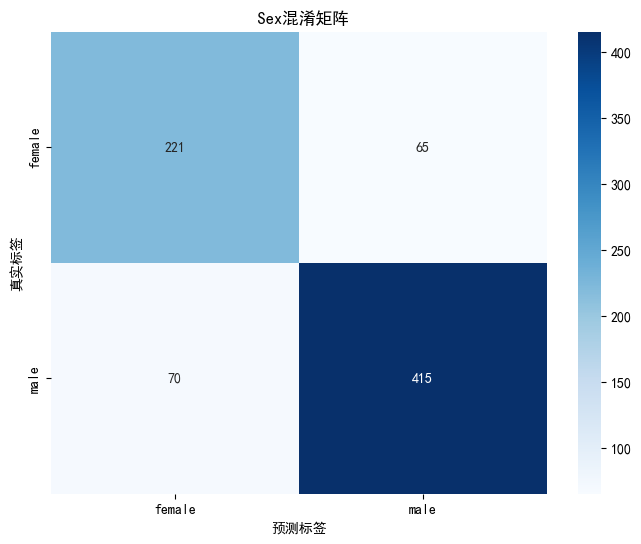

Age混淆矩阵:
        adult  child  senior  teen
adult     569      5       7    16
child      14     38       0    13
senior     10      0      19     1
teen       43      9       0    27



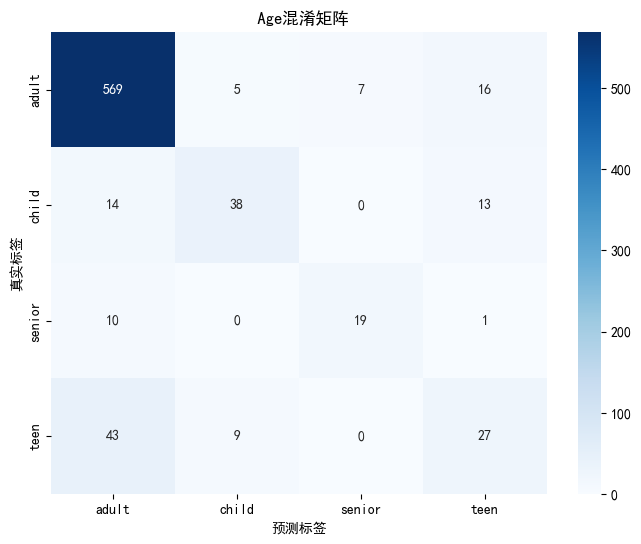

Race混淆矩阵:
          asian  black  hispanic  other  white
asian        11      0         0      0      4
black         0     43         0      1      4
hispanic      0      0         4      0      5
other         0      0         0      1      1
white         7      6         4      2    678



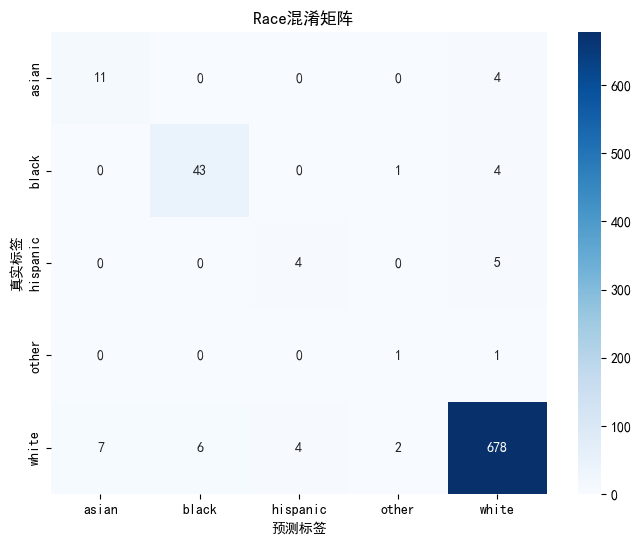

Face混淆矩阵:
         funny  serious  smiling
funny        3        6        4
serious     10      319       63
smiling      6       72      288



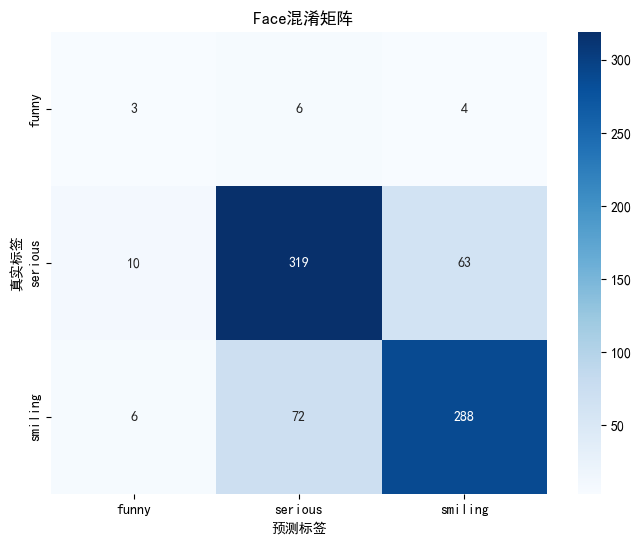

In [8]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from matplotlib import rcParams

# 指定支持中文的字体
rcParams['font.family'] = 'SimHei'  # 指定中文字体为黑体
rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 保存配置
plt.rcParams.update(rcParams)
# 生成每个分类任务的混淆矩阵
for feature_name in classifiers.keys():
    clf = classifiers[feature_name]
    y_test = y_tests[feature_name]
    le = label_encoders.get('_'+feature_name)  # 获取相应的LabelEncoder
    
    if le is None:
        print(f"标签编码未找到 {feature_name}")
        continue
    
    # 生成混淆矩阵
    cm_df = generate_confusion_matrix(clf, X_test, y_test, le)
    
    # 打印混淆矩阵
    print(f"{feature_name.capitalize()}混淆矩阵:\n{cm_df}\n")
    
    # 可视化混淆矩阵
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title(f' {feature_name.capitalize()}混淆矩阵')
    plt.ylabel('真实标签')
    plt.xlabel('预测标签')
    plt.show()